<a href="https://colab.research.google.com/github/sohiniroych/AI_with_Sohini_Notebooks/blob/main/Customized_chatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In this notebook, we learn about the stages to tune your own chat-GPT like Large Language Model. The 3 stages are as follows:


1.   Locate the Page with the answer (This is the context search phase that needs millions of attention neurons)
2.   Summarize the contents on the relevant page
3.  Paraphraze the summary to cound human like
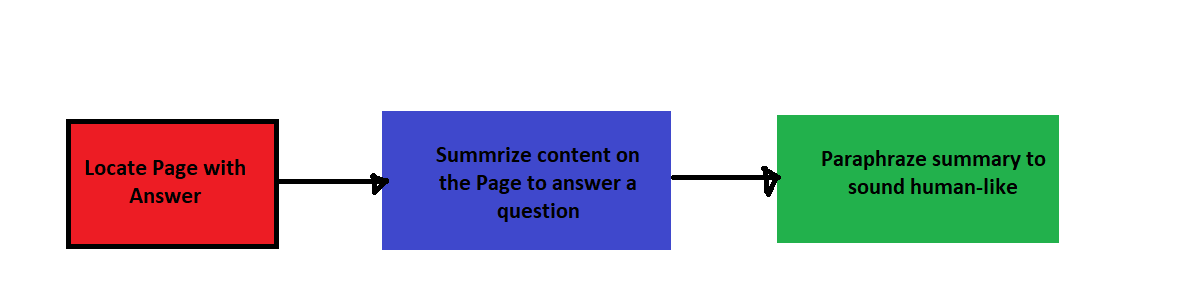

### Step 0: Install Transformer Model

In [1]:
## installation
# see https://twitter.com/huggingface/status/1242512382800400384
# details https://github.com/huggingface/transformers/releases/tag/v2.6.0
!pip install transformers --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import pipeline
import requests
import pprint
import time
pp = pprint.PrettyPrinter(indent=14)

In [3]:
# System crashes can hapen if using t5-3b and 11b
summarizer_t5 = pipeline(task='summarization', model="t5-large") # options: ‘t5-small’, ‘t5-base’, ‘t5-large’, ‘t5-3b’, ‘t5-11b’

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Step 1: Bring the pages with context. In this case we upload a file with all the text.

In [4]:
# Now connect to GDrive and load teh file with ALL CONTEXT
from google.colab import drive
import os
drive.mount('/content/drive')
# Change it if necessary
os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pathlib

list(pathlib.Path('./').glob('*.txt'))

[PosixPath('SCH Panel Summary Template-2022.txt'), PosixPath('about_me.txt')]

In [6]:
with open('about_me.txt') as f:
    sentences = f.readlines()
stripped_lines = [s.rstrip() for s in sentences]

In [7]:
text = " ".join(stripped_lines)
text

'I joined Accenture LLP, USA in October 2021 as Senior Manager and Global Image Automation Lead. We have worked on several client facing projects ranging from Sports Injury Prediction to Delivering Analytical Solutions and Data Products for Deal Pricing in Accenture. My recent interests include Document automation, OCR and Generative AI Solutions for Data Streams and Tabular Data. We have developed an Automated Language Generation System that is a precursor to a chatGPT solution for Tabular Data.  Prior to Accenture, I was a part of a 4-person team that co-founded FourthBrain.ai amidst the COVID-19 crisis in mid 2020. Here I got to develop specialized Educational content to train and weather proof candidates in the field of Machine Learning. Our curriculum included rapid prototyping in Python, along with hands on Software knowledge to enable Continuous Deployment of ML applications. I believe in Life-long learning and continue to learn every single day through content creation, bloggin

### Step 2: Summarize the content of the page that was provided

In [8]:
t0 = time.time() # timer
summary = summarizer_t5(text, min_length=300, max_length=500) # change min_ and max_length for different output
print("Summarization took " + str(round((time.time() - t0) / 60, 2)) + " minutes.")

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Summarization took 2.55 minutes.


In [9]:
summary[0]['summary_text']

"prior to Accenture, i was a part of a 4-person team that co-founded FourthBrain.ai . my specialization includes out-of-the-box AI solutions applied to inter-disciplinary topics . I received my Ph.D. in electrical and computer engineering from university of minnesota . i continue to learn every single day through content creation, blogging, YouTube videos and Research papers - i believe in Life-long learning - and continue to study at the highest level of education a a- aa nnn na en a, n -n aen n- nen ena heaaa-na-en -a  asa à agré à la enne ap .n ànnacré à partir à une à des à un à, à lire à être s à-être au-en-l' à son àvà sè à1 àlà àon àà à-à .......................................................................................................................................................................................................................................................................... .............................................................. ................

In [10]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step 3: Paraphraze the summary

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cpu"

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

sentence = summary[0]['summary_text']
# sentence = "What are the ingredients required to bake a perfect cake?"
# sentence = "What is the best possible approach to learn aeronautical engineering?"
# sentence = "Do apples taste better than oranges in general?"


text =  "paraphrase: " + sentence + " </s>"


max_len = 500

encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)


# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
beam_outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    do_sample=True,
    max_length=800,
    top_k=500,
    top_p=0.98,
    early_stopping=True,
    num_return_sequences=3
)


print ("Paraphrased sentences :: ")
final_outputs =[]
for beam_output in beam_outputs:
    sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    if sent.lower() != sentence.lower() and sent not in final_outputs:
        final_outputs.append(sent)

for i, final_output in enumerate(final_outputs):
    print("{}: {}".format(i, final_output))

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Paraphrased sentences :: 
0: After completing my Ph.D. in electrical and computer engineering from university of Minnesota, I joined the team at FourthBrain.ai and have been passionate about deep learning and collaboration with diverse fields, studying lifelong skills.
1: I'm a former member of the 4-person team that co-founded FourthBrain.ai. I'm passionate about exploring innovative AI options that intersect various fields and have completed my Ph.D. in electrical and computer engineering from the University of Minnesota. I continue to grow and improve through daily content creation, blogging, YouTube videos, and research papers. I have a strong belief in lifelong learning, so I aim to study at the highest level.
2: I worked for Accenture and was recently part of a 4-person team that created FourthBrain.ai. I have an affinity for innovative AI concepts that are applied across different fields. I received my Ph.D. from the university of Minnesota and am still learning today. I am pass

In [12]:
final_outputs[0]

'After completing my Ph.D. in electrical and computer engineering from university of Minnesota, I joined the team at FourthBrain.ai and have been passionate about deep learning and collaboration with diverse fields, studying lifelong skills.'

In [13]:
final_outputs[1]

"I'm a former member of the 4-person team that co-founded FourthBrain.ai. I'm passionate about exploring innovative AI options that intersect various fields and have completed my Ph.D. in electrical and computer engineering from the University of Minnesota. I continue to grow and improve through daily content creation, blogging, YouTube videos, and research papers. I have a strong belief in lifelong learning, so I aim to study at the highest level."

In [14]:
final_outputs[2]

'I worked for Accenture and was recently part of a 4-person team that created FourthBrain.ai. I have an affinity for innovative AI concepts that are applied across different fields. I received my Ph.D. from the university of Minnesota and am still learning today. I am passionate about Life-Long learning and enjoy creating content, blogging, and publishing videos and papers.'

### This example demonstrates how the chatGPT features operate. To further fine tune, you can try question answering models in Step 2 followed by further fine-tuning the paraphrazer.
E.g. https://huggingface.co/deepset/tinyroberta-squad2

https://huggingface.co/potsawee/t5-large-generation-squad-QuestionAnswer

https://huggingface.co/mrm8488/t5-base-finetuned-summarize-news

https://huggingface.co/ramsrigouthamg/t5-large-paraphraser-diverse-high-quality

